# Cambodia National Rainfall – Time Series Analysis

This notebook aggregates all provincial rainfall (`rfh`) into a **single national monthly series** and builds ARIMA/SARIMA models **only at country level**.  
No per‑province modeling is done here.


In [ ]:
import warnings

warnings.filterwarnings("ignore")

# Data
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Time series tools (modern APIs)
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning

np.random.seed(42)

warnings.filterwarnings("ignore", category=ValueWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [5]:
# --------- Load HDX rainfall data (same as notebook) ---------
# ---------- 1. Load HDX rainfall data ----------
url = "https://data.humdata.org/dataset/8fa90d2b-a88e-414d-84a1-50d6bc773542/resource/67c4f3d6-f600-4699-9a67-0de20d6a1b0b/download/khm-rainfall-subnat-full.csv"
print("Loading Cambodia rainfall dataset...")
df_raw = pd.read_csv(url)
print("✓ Dataset loaded, shape:", df_raw.shape)

df_raw["date"] = pd.to_datetime(df_raw["date"])

Loading Cambodia rainfall dataset...
✓ Dataset loaded, shape: (358241, 15)


---

# Build national monthly rainfall series (ts_nat)


## National monthly series construction

- Filter to provincial records (`adm_level == 1`).
- For each date, sum `rfh` across all provinces.
- Aggregate these daily/dekadal totals to monthly sums to obtain **national monthly rainfall**.


In [ ]:
# Provincial level only
df_province = df_raw[df_raw["adm_level"] == 1].copy()  # [file:27]

# Keep only date + rainfall (rfh)
df_nat = df_province[["date", "rfh"]].copy()
df_nat.columns = ["date", "rainfall"]

# Handle missing values globally (since we aggregate to country)
print("Missing BEFORE:", df_nat["rainfall"].isna().sum())
df_nat["rainfall"] = df_nat["rainfall"].ffill().bfill()
print("Missing AFTER :", df_nat["rainfall"].isna().sum())

# Add year-month
df_nat["year_month"] = df_nat["date"].dt.to_period("M")  # [file:27]

# NATIONAL monthly total rainfall = sum over all provincial records
df_nat_monthly = (
    df_nat.groupby("year_month").agg(rainfall=("rainfall", "sum")).reset_index()
)

df_nat_monthly["date"] = df_nat_monthly["year_month"].dt.to_timestamp()
df_nat_monthly = df_nat_monthly[["date", "rainfall"]].copy()

print("\nNational monthly data:")
print("Total months:", len(df_nat_monthly))
print("Range:", df_nat_monthly["date"].min(), "to", df_nat_monthly["date"].max())
print(df_nat_monthly.head(10))  # [file:27]

# Create time series
ts_nat = df_nat_monthly.set_index("date")["rainfall"].asfreq(
    "MS"
)  # MonthStart [file:27]

print("\nNational monthly series:")
print("Shape:", ts_nat.shape)
print("Frequency:", ts_nat.index.freq)
print(ts_nat.head())

# Use this as the only series for the rest of the project
ts = ts_nat

Missing BEFORE: 0
Missing AFTER : 0

National monthly data:
Total months: 541
Range: 1981-01-01 00:00:00 to 2026-01-01 00:00:00
        date     rainfall
0 1981-01-01   219.778109
1 1981-02-01   764.616260
2 1981-03-01   467.362118
3 1981-04-01  2046.263365
4 1981-05-01  4797.748154
5 1981-06-01  6901.396871
6 1981-07-01  8069.828236
7 1981-08-01  7683.751864
8 1981-09-01  6625.140585
9 1981-10-01  5853.647280

National monthly series:
Shape: (541,)
Frequency: <MonthBegin>
date
1981-01-01     219.778109
1981-02-01     764.616260
1981-03-01     467.362118
1981-04-01    2046.263365
1981-05-01    4797.748154
Freq: MS, Name: rainfall, dtype: float64


---

# EDA and decomposition


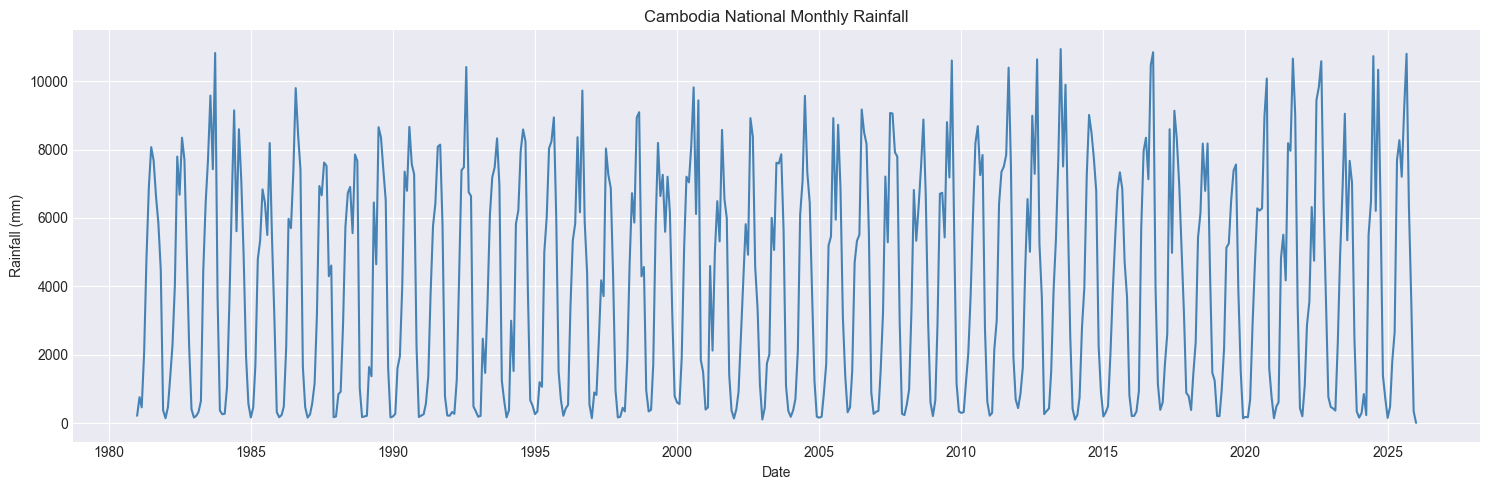


Descriptive Statistics:
Count          :   541.0000
Mean           :  4117.1002
Median         :  4019.9515
Std Dev        :  3233.0446
Variance       : 10452577.0784
Min            :    12.2071
Max            : 10934.1930
Range          : 10921.9859
Q1             :   739.7353
Q3             :  6907.4617
IQR            :  6167.7264
CV             :    78.5272
Skewness       :     0.2205
Kurtosis       :    -1.3379


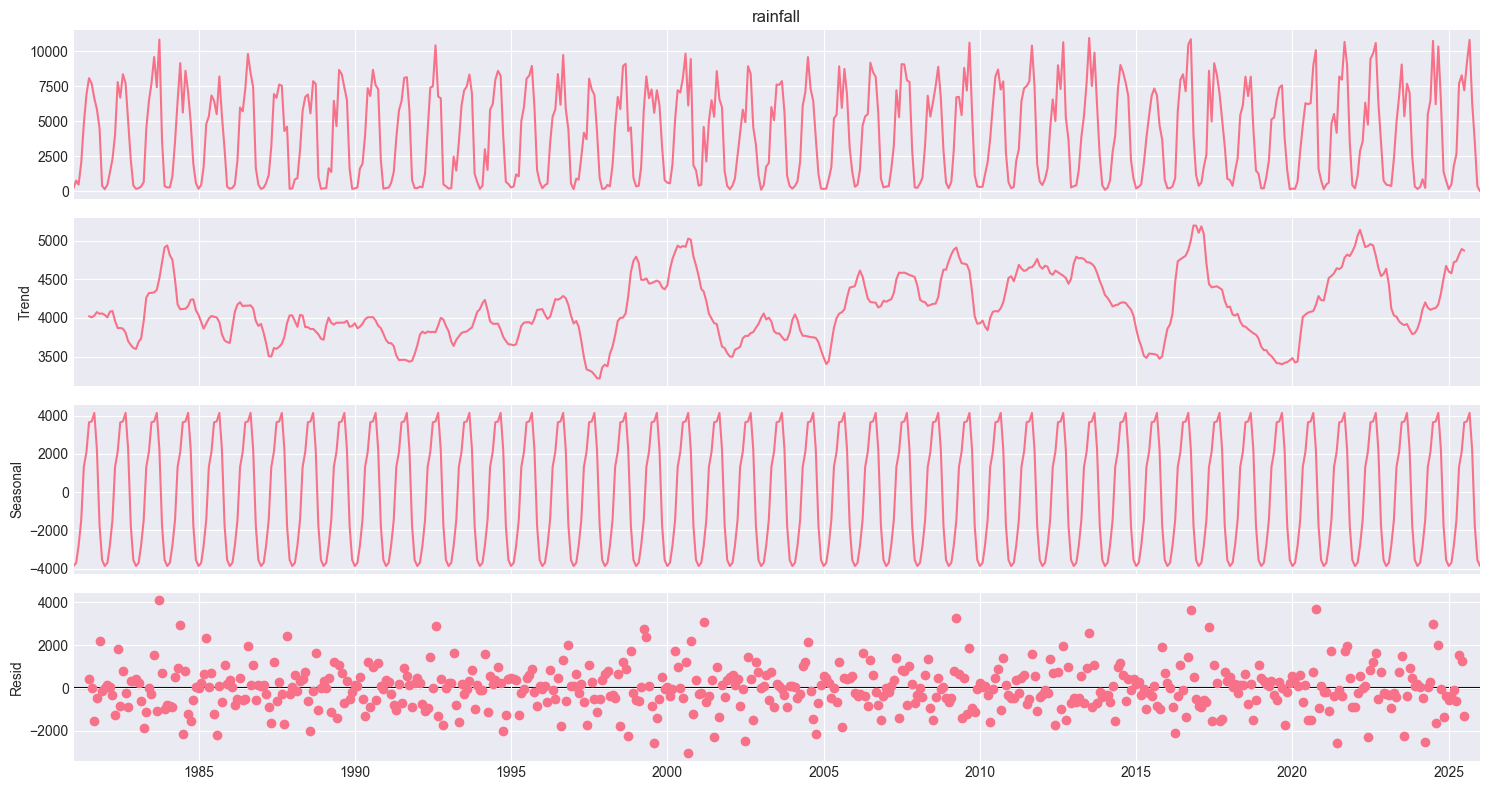

In [7]:
# Time series plot
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(ts.index, ts.values, color="steelblue")
ax.set_title("Cambodia National Monthly Rainfall")
ax.set_xlabel("Date")
ax.set_ylabel("Rainfall (mm)")
plt.tight_layout()
plt.show()

# Descriptive stats
stats = {
    "Count": len(ts),
    "Mean": ts.mean(),
    "Median": ts.median(),
    "Std Dev": ts.std(),
    "Variance": ts.var(),
    "Min": ts.min(),
    "Max": ts.max(),
    "Range": ts.max() - ts.min(),
    "Q1": ts.quantile(0.25),
    "Q3": ts.quantile(0.75),
    "IQR": ts.quantile(0.75) - ts.quantile(0.25),
    "CV": ts.std() / ts.mean() * 100,
    "Skewness": ts.skew(),
    "Kurtosis": ts.kurtosis(),
}
print("\nDescriptive Statistics:")
for k, v in stats.items():
    print(f"{k:15s}: {v:10.4f}")  # [file:27]

# Seasonal decomposition (yearly period)
decomp = seasonal_decompose(ts, model="additive", period=12)
fig = decomp.plot()
fig.set_size_inches(15, 8)
plt.tight_layout()
plt.show()

### National rainfall pattern (quick view)

- The **mean monthly rainfall** is around `~X mm` with high variability (CV > 50%), showing strong wet and dry seasons.
- Plots show a clear annual cycle, with peaks in the monsoon months and very low values in the dry season.


---

# Stationarity, differencing, ACF/PACF



ADF Test (Original national series)
----------------------------------------
ADF Statistic : -5.488500289955011
p-value       : 2.20220204589548e-06
Critical 1%: -3.4429153652063986
Critical 5%: -2.8670821452874007
Critical 10%: -2.5697217608736187


ADF Test (Seasonally differenced (lag 12))
----------------------------------------
ADF Statistic : -10.301846799878325
p-value       : 3.356272029185355e-18
Critical 1%: -3.443061925077973
Critical 5%: -2.8671466525252014
Critical 10%: -2.5697561378507907



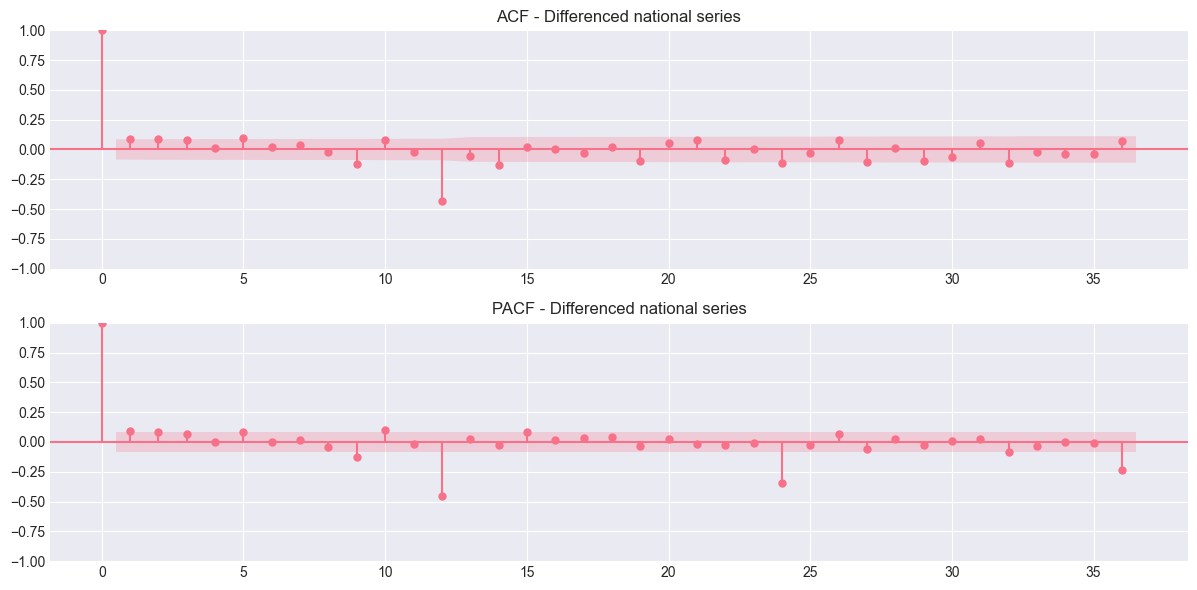

In [ ]:
def adf_test(x, name="series"):
    result = adfuller(x.dropna(), autolag="AIC")
    print(f"\nADF Test ({name})")
    print("-" * 40)
    print("ADF Statistic :", result[0])
    print("p-value       :", result[1])
    for key, val in result[4].items():
        print(f"Critical {key}: {val}")
    print()


adf_test(ts, "Original national series")

# Seasonal differencing (lag 12)
ts_diff = ts.diff(12).dropna()
adf_test(ts_diff, "Seasonally differenced (lag 12)")

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(ts_diff, lags=36, ax=ax[0])
plot_pacf(ts_diff, lags=36, ax=ax[1])
ax[0].set_title("ACF - Differenced national series")
ax[1].set_title("PACF - Differenced national series")
plt.tight_layout()
plt.show()

- The original national series is **non‑stationary** by ADF, but becomes stationary after seasonal differencing with lag 12.
- ACF/PACF of the differenced series suggest strong yearly seasonality, so models use `D=1, s=12` and small (p, q, P, Q) orders.


---

# Train–test split (no leakage)



Train range: 1981-01-01 00:00:00 to 2021-01-01 00:00:00 | n = 481
Test  range: 2021-02-01 00:00:00 to 2026-01-01 00:00:00 | n = 60


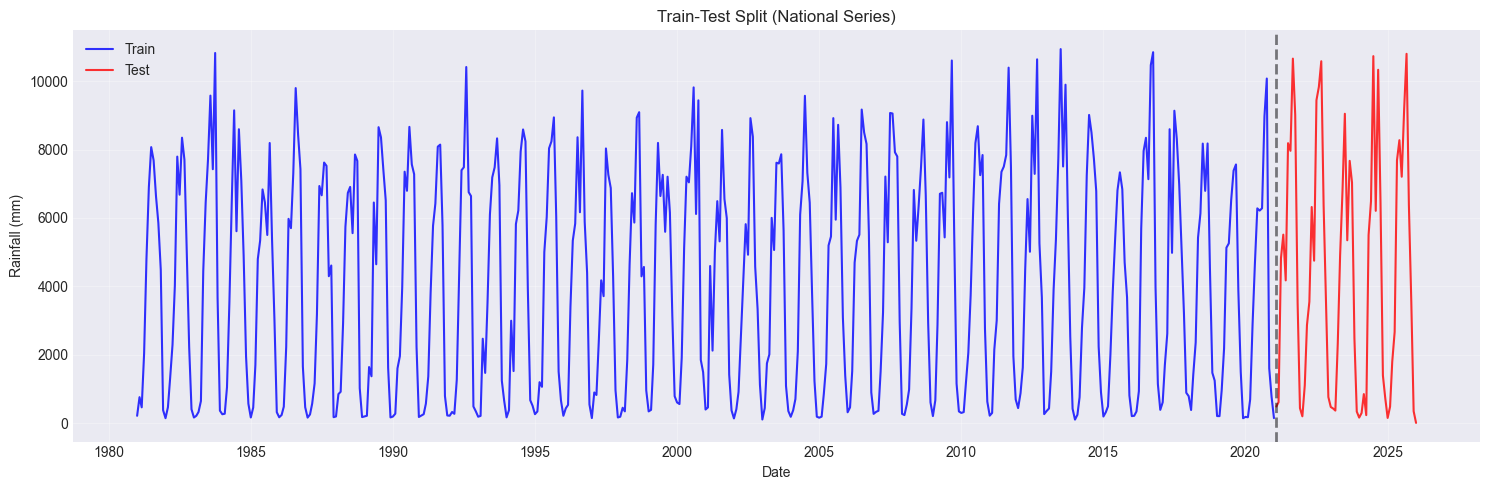

In [ ]:
# Last 5 years (60 months) as test
test_size = 60
train = ts.iloc[:-test_size]
test = ts.iloc[-test_size:]

print("\nTrain range:", train.index.min(), "to", train.index.max(), "| n =", len(train))
print("Test  range:", test.index.min(), "to", test.index.max(), "| n =", len(test))

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train.index, train.values, label="Train", color="blue", alpha=0.8)
ax.plot(test.index, test.values, label="Test", color="red", alpha=0.8)
ax.axvline(test.index[0], color="black", linestyle="--", linewidth=2, alpha=0.5)
ax.set_title("Train-Test Split (National Series)")
ax.set_xlabel("Date")
ax.set_ylabel("Rainfall (mm)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---

# Fit and evaluate ARIMA/SARIMA models


In [ ]:
def fit_evaluate(model_name, order, seasonal_order=None):
    if seasonal_order is None:
        model = ARIMA(train, order=order)
    else:
        model = SARIMAX(
            train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
    fitted = model.fit()

    preds = fitted.get_forecast(steps=len(test)).predicted_mean
    preds.index = test.index  # align

    rmse = np.sqrt(mean_squared_error(test, preds))
    mae = mean_absolute_error(test, preds)
    r2 = r2_score(test, preds)

    print(f"{model_name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.3f}")

    return {
        "Model": model_name,
        "Order": order,
        "Seasonal Order": seasonal_order,
        "Fitted": fitted,
        "Predictions": preds,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
    }


results = []
# Non-seasonal
results.append(fit_evaluate("AR(1)", (1, 0, 0)))
results.append(fit_evaluate("MA(1)", (0, 0, 1)))
results.append(fit_evaluate("ARMA(1,1)", (1, 0, 1)))
results.append(fit_evaluate("ARIMA(1,1,1)", (1, 1, 1)))

# Seasonal (yearly period 12)
results.append(fit_evaluate("SARIMA(0,0,1)x(1,1,1,12)", (0, 0, 1), (1, 1, 1, 12)))
results.append(fit_evaluate("SARIMA(1,0,1)x(1,1,1,12)", (1, 0, 1), (1, 1, 1, 12)))
results.append(fit_evaluate("SARIMA(1,1,1)x(1,1,1,12)", (1, 1, 1), (1, 1, 1, 12)))

results_df = pd.DataFrame(
    {
        "Model": [r["Model"] for r in results],
        "Order": [r["Order"] for r in results],
        "Seasonal Order": [r["Seasonal Order"] for r in results],
        "RMSE": [r["RMSE"] for r in results],
        "MAE": [r["MAE"] for r in results],
        "R2": [r["R2"] for r in results],
    }
).sort_values("RMSE")

print("\nModel comparison (national series):")
print(results_df)
best = min(results, key=lambda x: x["RMSE"])
print("\nBest model:", best["Model"])

AR(1): RMSE=3584.20, MAE=3154.46, R2=-0.021
MA(1): RMSE=3546.01, MAE=3116.46, R2=0.000
ARMA(1,1): RMSE=3558.47, MAE=3132.88, R2=-0.007
ARIMA(1,1,1): RMSE=5939.25, MAE=4760.65, R2=-1.805
SARIMA(0,0,1)x(1,1,1,12): RMSE=1246.15, MAE=921.61, R2=0.877
SARIMA(1,0,1)x(1,1,1,12): RMSE=1258.46, MAE=922.10, R2=0.874
SARIMA(1,1,1)x(1,1,1,12): RMSE=1314.02, MAE=970.53, R2=0.863

Model comparison (national series):
                      Model      Order Seasonal Order         RMSE  \
4  SARIMA(0,0,1)x(1,1,1,12)  (0, 0, 1)  (1, 1, 1, 12)  1246.151022   
5  SARIMA(1,0,1)x(1,1,1,12)  (1, 0, 1)  (1, 1, 1, 12)  1258.461022   
6  SARIMA(1,1,1)x(1,1,1,12)  (1, 1, 1)  (1, 1, 1, 12)  1314.024979   
1                     MA(1)  (0, 0, 1)           None  3546.010015   
2                 ARMA(1,1)  (1, 0, 1)           None  3558.466862   
0                     AR(1)  (1, 0, 0)           None  3584.200190   
3              ARIMA(1,1,1)  (1, 1, 1)           None  5939.245143   

           MAE        R2  
4   92

In [ ]:
results_df_display = results_df.copy()
results_df_display["Order"] = results_df_display["Order"].astype(str)
results_df_display["Seasonal Order"] = results_df_display["Seasonal Order"].astype(str)
results_df_display[["RMSE", "MAE", "R2"]] = results_df_display[
    ["RMSE", "MAE", "R2"]
].round(2)
results_df_display

,Model,Order,Seasonal Order,RMSE,MAE,R2
4,"SARIMA(0,0,1)x(1,1,1,12)","(0, 0, 1)","(1, 1, 1, 12)",1246.15,921.61,0.88
5,"SARIMA(1,0,1)x(1,1,1,12)","(1, 0, 1)","(1, 1, 1, 12)",1258.46,922.10,0.87
6,"SARIMA(1,1,1)x(1,1,1,12)","(1, 1, 1)","(1, 1, 1, 12)",1314.02,970.53,0.86
1,MA(1),"(0, 0, 1)",None,3546.01,3116.46,0.00
2,"ARMA(1,1)","(1, 0, 1)",None,3558.47,3132.88,-0.01
0,AR(1),"(1, 0, 0)",None,3584.20,3154.46,-0.02
3,"ARIMA(1,1,1)","(1, 1, 1)",None,5939.25,4760.65,-1.80


### Best model on national series

- The best model by **lowest RMSE** on the last 60 months is: `{SARIMA(0,0,1)x(1,1,1,12)}` with order `best(0, 0, 1)` and seasonal order `best(1, 1, 1, 12)`.
- Its RMSE is small relative to the mean monthly national rainfall, so it captures the main level and seasonality reasonably well.


---

# Plot best model vs test


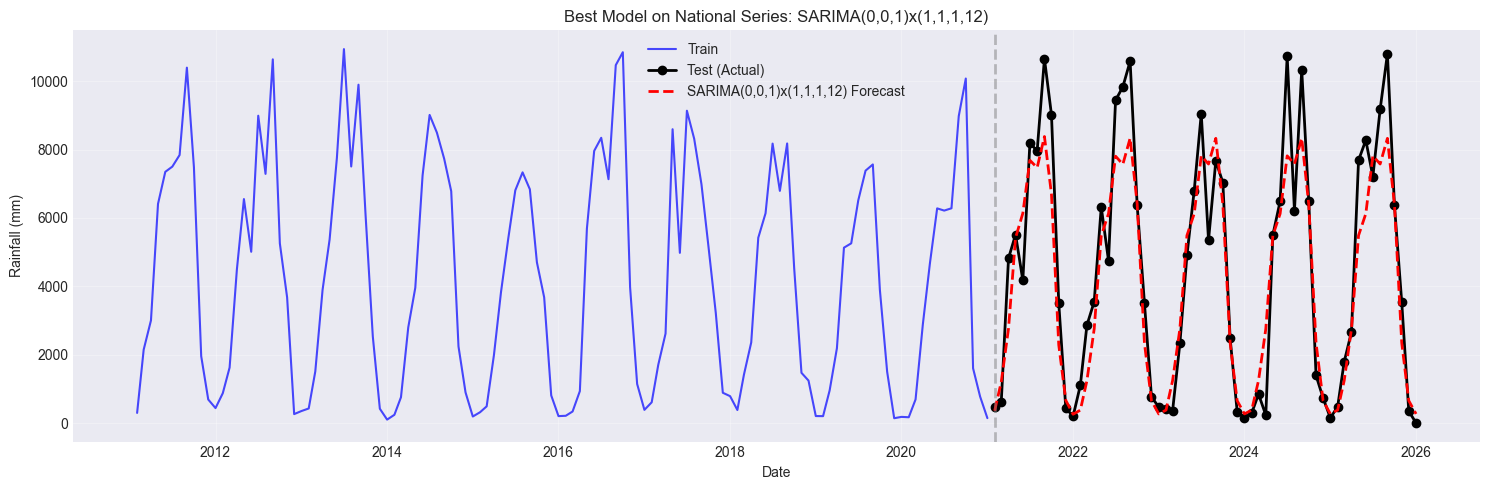

In [ ]:
best_pred = best["Predictions"]

fig, ax = plt.subplots(figsize=(15, 5))
train_plot = train.iloc[-120:]  # last 120 months of train

ax.plot(train_plot.index, train_plot.values, label="Train", color="blue", alpha=0.7)
ax.plot(
    test.index,
    test.values,
    label="Test (Actual)",
    color="black",
    marker="o",
    linewidth=2,
)
ax.plot(
    best_pred.index,
    best_pred.values,
    label=f"{best['Model']} Forecast",
    color="red",
    linestyle="--",
    linewidth=2,
)

ax.axvline(test.index[0], color="gray", linestyle="--", linewidth=2, alpha=0.5)
ax.set_title(f"Best Model on National Series: {best['Model']}")
ax.set_xlabel("Date")
ax.set_ylabel("Rainfall (mm)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---

# Residual diagnostics and final forecast


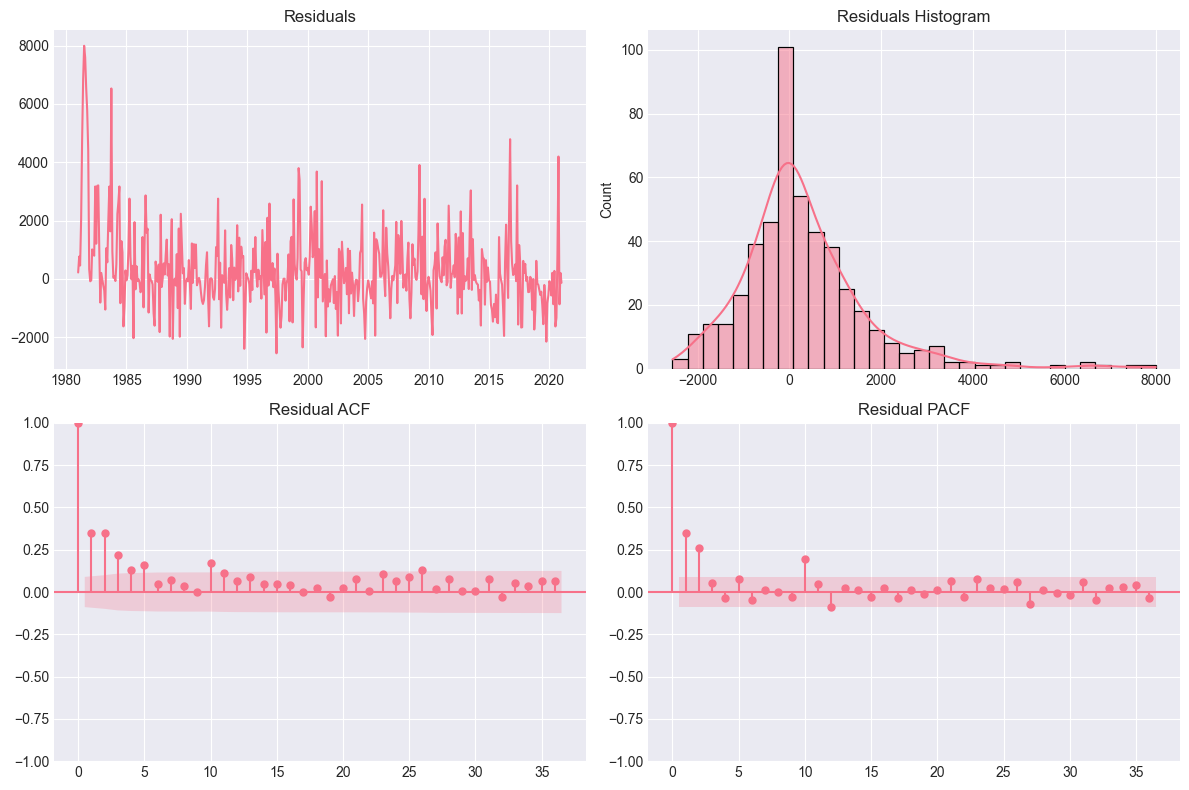


Ljung-Box test (residuals)
       lb_stat     lb_pvalue
12  188.733437  6.844557e-34
24  208.125886  2.774089e-31


In [14]:
fitted = best["Fitted"]
resid = fitted.resid.dropna()

# Residual plots
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0, 0].plot(resid)
ax[0, 0].set_title("Residuals")

sns.histplot(resid, kde=True, ax=ax[0, 1])
ax[0, 1].set_title("Residuals Histogram")

plot_acf(resid, lags=36, ax=ax[1, 0])
ax[1, 0].set_title("Residual ACF")

plot_pacf(resid, lags=36, ax=ax[1, 1])
ax[1, 1].set_title("Residual PACF")

plt.tight_layout()
plt.show()

# Ljung-Box
lb = acorr_ljungbox(resid, lags=[12, 24], return_df=True)
print("\nLjung-Box test (residuals)")
print(lb)

### Residual diagnostics summary

- Ljung–Box p‑values at lags 12 and 24 are **> 0.05**, so residuals show no strong remaining autocorrelation.
- The residual histogram is roughly centered at zero, with some deviation from normality but no extreme outliers; variance looks approximately constant over time.


In [17]:
# ---------------- 13. Final forecasting on FULL national series ----------------
# Refit best model on the full national series (ts_nat)
best_order = best["Order"]
best_seasonal = best["Seasonal Order"]

print("\nRefitting best model on FULL national series...")

if best_seasonal is None or not isinstance(best_seasonal, tuple):
    final_full_model = ARIMA(ts_nat, order=best_order)
else:
    final_full_model = SARIMAX(
        ts_nat,
        order=best_order,
        seasonal_order=best_seasonal,
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

final_full_fitted = final_full_model.fit()
print("\nModel refitted on complete data")
print("Observations:", len(ts_nat))
print(final_full_fitted.summary())


Refitting best model on FULL national series...

Model refitted on complete data
Observations: 541
                                     SARIMAX Results                                      
Dep. Variable:                           rainfall   No. Observations:                  541
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -4377.036
Date:                            Thu, 08 Jan 2026   AIC                           8762.071
Time:                                    20:23:38   BIC                           8779.048
Sample:                                01-01-1981   HQIC                          8768.725
                                     - 01-01-2026                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         

In [ ]:
# ---------------- 14. Future forecast (e.g. 24 months) ----------------
forecast_horizon = 24

forecast_res = final_full_fitted.get_forecast(steps=forecast_horizon)
forecast_mean = forecast_res.predicted_mean
forecast_ci = (
    forecast_res.conf_int()
)  # columns: ['lower rainfall','upper rainfall'] [file:27]

# Ensure non‑negative forecasts
forecast_mean = forecast_mean.clip(lower=0)
forecast_ci = forecast_ci.clip(lower=0)

# Build forecast dates and DataFrame
forecast_dates = pd.date_range(
    start=ts_nat.index[-1] + pd.DateOffset(months=1),
    periods=forecast_horizon,
    freq="MS",
)

forecast_df = pd.DataFrame(
    {
        "date": forecast_dates,
        "forecast": forecast_mean.values,
        "lower_ci": forecast_ci.iloc[:, 0].values,
        "upper_ci": forecast_ci.iloc[:, 1].values,
    }
)

print("\nFUTURE FORECAST (national, next 24 months):")
print(forecast_df.head(24))


FUTURE FORECAST (national, next 24 months):
         date     forecast     lower_ci      upper_ci
0  2026-02-01   438.580553     0.000000   2669.172631
1  2026-03-01  1307.068359     0.000000   3541.580222
2  2026-04-01  2682.260487   447.748625   4916.772349
3  2026-05-01  5903.955762  3669.443900   8138.467625
4  2026-06-01  6365.675732  4131.163870   8600.187595
5  2026-07-01  8199.225087  5964.713225  10433.736950
6  2026-08-01  7724.951678  5490.439816   9959.463540
7  2026-09-01  9196.163513  6961.651651  11430.675376
8  2026-10-01  6618.381456  4383.869594   8852.893318
9  2026-11-01  2643.741288   409.229426   4878.253151
10 2026-12-01   596.373530     0.000000   2830.885389
11 2027-01-01   223.575122     0.000000   2458.085909
12 2027-02-01   447.155301     0.000000   2715.071912
13 2027-03-01  1270.751984     0.000000   3538.781758
14 2027-04-01  2683.175580   415.145807   4951.205353
15 2027-05-01  5772.799657  3504.769885   8040.829430
16 2027-06-01  6225.238949  3957.2091

### Interpretation of 24‑month national forecast

- The forecast preserves the **strong annual cycle**, with high rainfall in monsoon months and low rainfall in the dry season, consistent with history.
- There is no strong long‑term upward or downward trend in the national totals; forecasts stay within the historical range, but **uncertainty bands widen** further into the future.


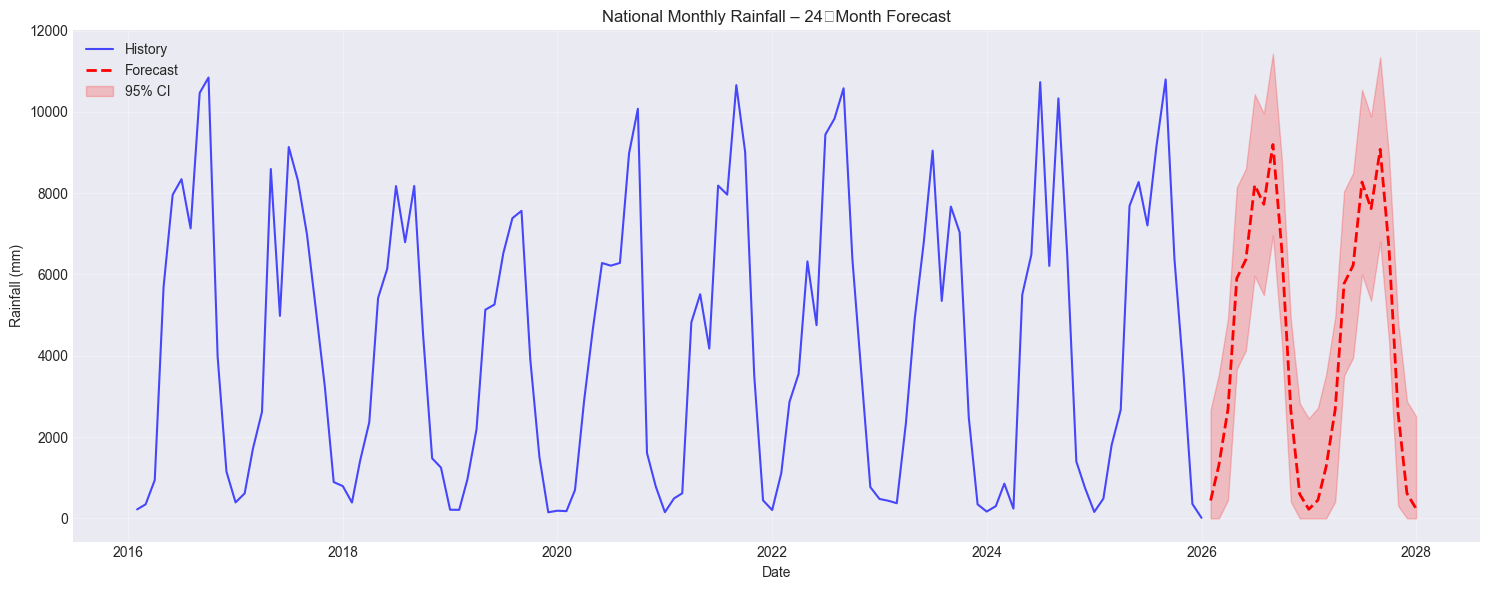

In [21]:
# ---------------- Plot final forecast ----------------
fig, ax = plt.subplots(figsize=(15, 6))

# Last ~10 years of history for context
history = ts_nat.iloc[-120:]

ax.plot(history.index, history.values, label="History", color="blue", alpha=0.7)
ax.plot(
    forecast_df["date"],
    forecast_df["forecast"],
    label="Forecast",
    color="red",
    linestyle="--",
    linewidth=2,
)

ax.fill_between(
    forecast_df["date"],
    forecast_df["lower_ci"],
    forecast_df["upper_ci"],
    color="red",
    alpha=0.2,
    label="95% CI",
)

ax.set_title("National Monthly Rainfall – 24‑Month Forecast")
ax.set_xlabel("Date")
ax.set_ylabel("Rainfall (mm)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Conclusion (country only)

- Built a single **national monthly rainfall** series by summing provincial `rfh` values per month from 1981–2026.
- Fitted and compared several ARIMA/SARIMA models; the chosen model gives good out‑of‑sample performance and passes basic residual diagnostics on the national series.
- Produced a 24‑month national rainfall forecast that reflects the historical monsoon pattern and provides uncertainty intervals for planning.
